In [69]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from fisher.combine_plotter import read_and_merge_data
import seaborn as sns
from typing import List, Tuple
# from define_sectors import visualize_sectors_map

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patches as patches

In [70]:
def retrieve_data(path: str, filename: str) -> Tuple[List[str], List[float], List[List[float]]]:
    """
    Retrieve data from the given path and filename

    Args:
        path (str): The path to the data
        filename (str): The filename of the data

    Returns:
        list: The complete list of goods available
        list: The prices of each good
        list: The allocation of each good to each agent
    """
    # Get name of the file containing data from after the integral allocation
    leftside, rightside = filename.rsplit('_', 1)
    number, ext = rightside.split('.')
    post_filename = f"{leftside}_after_{number}.{ext}"

    # Paths
    filename_path = path + filename
    post_filename_path = path + post_filename

    # Load data
    with open(filename_path, 'rb') as file:
        post_fisher_data = pkl.load(file)
    with open(post_filename_path, 'rb') as file:
        post_int_data = pkl.load(file)

    # Pull out goods, good prices, and all data on integral allocations
    goods, good_prices = post_fisher_data["goods_list"], post_fisher_data["prices"]
    allocation_data = post_int_data["agents_data"]

    def map_agent_items_to_total(agent_items, agent_amounts, total_items):
        """
        Create a map from each item to the amount of that item the agent has or 0 if they do not have it.

        Args:
            agent_items (list): The items the agent has
            agent_amounts (list): The amount of each item the agent has
            total_items (list): The total items available

        Returns:
            list: The amount of each item the agent has or 0 if they do not have it
        """
        # Create a dictionary from agent_items to agent_amounts
        agent_dict = dict(zip(agent_items, agent_amounts))
        
        # Create the result list: map total_items to the amounts or 0 if not in agent_dict
        result = [agent_dict.get(item, 0) for item in total_items]
        
        return result

    # Fill out each agent's allocation with 0s for missing goods
    agents_allocation = [agent["final_allocation"] for _, agent in allocation_data.items()]
    agent_goods_lists = [agent["agent_goods_list"] for _, agent in allocation_data.items()]
    allocation = [map_agent_items_to_total(agent_good_list, agent_allocation, goods) for agent_allocation, agent_good_list in zip(agents_allocation, agent_goods_lists)]

    return goods, good_prices, allocation


In [124]:
def find_region_prices_and_congestion(goods, good_prices, allocation):
    """
    Pull the prices and congestion of each region(good)

    Returns:
        int: The maximum time
        dict: The price of each region at each time
        dict: The congestion in each region at each time
        dict: The prices of goods
    """
    def init_dict(keys, factory):
        return {key: factory() for key in keys}

    # Create lists of keys
    vertiport_keys = [f"V00{id}" for id in range(1, 5)]
    vertiport_dep_keys = [f"V00{id}_dep" for id in range(1, 5)]
    vertiport_arr_keys = [f"V00{id}_arr" for id in range(1, 5)]
    sector_keys = [f"S00{id}" for id in range(1, 13)]
    all_keys = vertiport_keys + vertiport_dep_keys + vertiport_arr_keys + sector_keys

    # Initialize dictionaries
    sector_prices    = init_dict(all_keys, dict)
    goods_added      = init_dict(all_keys, list)
    sector_congestion = init_dict(all_keys, dict)

    max_time = 0
    indices = list(range(len(good_prices)))
    for i, p, good in zip(indices, good_prices, goods):
        if len(good) != 2:
            continue
        origin = good[0].split('_')[0]
        destination = good[1].split('_')[0]
        this_time = int(good[0].split('_')[1])
        max_time = max(max_time, this_time)
        if origin[0] == "V" and destination[0] == "V":
            if good[0][-3:] != "arr" and good[1][-3:] != "dep":
                # Parked goods
                base = good[1][:4]
            elif good[1][-3:] == "dep":
                # Departing goods
                base = good[1][:4] + "_dep"
            elif good[0][-3:] == "arr":
                # Arriving goods
                base = good[0][:4] + "_arr"
            sector_prices[base][this_time] = p
            sector_congestion[base][this_time] = sum([agent_allocation[i] for agent_allocation in allocation])
            # sector_prices[base].append(p)
            goods_added[base].append(good)
        elif origin[0] == "S" and destination[0] == "S":
            if origin == destination:
                base = origin
                # sector_prices[base].append(p)
                sector_prices[base][this_time] = p
                sector_congestion[base][this_time] = sum([agent_allocation[i] for agent_allocation in allocation])
                goods_added[base].append(good)

    sector_price_vs_time = {}
    sector_congestion_vs_time = {}
    for sector, price_dict in sector_prices.items():
        sector_price_vs_time[sector] = np.zeros(max_time+1)
        for this_time, price in price_dict.items():
            sector_price_vs_time[sector][this_time] = price

    for sector, congestion_dict in sector_congestion.items():
        sector_congestion_vs_time[sector] = np.zeros(max_time+1)
        for this_time, congestion in congestion_dict.items():
            sector_congestion_vs_time[sector][this_time] = congestion

    return max_time, sector_price_vs_time, sector_congestion_vs_time, sector_prices, sector_congestion


In [72]:
def plot_prices_and_congestion(sector_price_vs_time, sector_congestion_vs_time, path, max_time, one_plot=True):
    """
    Plot the prices and congestion of each sector over time

    Args:
        sector_price_vs_time (dict): The price of each sector at each time
        sector_congestion_vs_time (dict): The congestion in each sector at each time
    """
    colors = sns.color_palette("colorblind", 6)
    color_ind = 0
    if one_plot:
        # Plotted as subplots
        _, (ax1, ax3, ax4) = plt.subplots(3, 1, figsize=(8, 8))


        for sector, prices in sector_price_vs_time.items():
            if any(prices > 0.05):
                ax1.plot(prices, label=sector, color=colors[color_ind])
                color_ind += 1
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Price")
        ax1.set_title("Good prices vs time")
        ax1.legend()

        # for sector, congestion in sector_congestion_vs_time.items():
        #     if sector[0] == "V" and sector[-1] != 'r' and sector [-1] != 'p' and any(congestion > 0.05):
        #         ax2.plot(congestion, label=f"{sector}")
        # ax2.plot(10*np.ones(max_time+1), "--", label="Congestion threshold")
        #     # plt.
        # ax2.set_xlabel("Time")
        # ax2.set_ylabel("Congestion")
        # ax2.set_title("Congestion vs time")
        # ax2.legend()

        color_ind = 0
        for sector, congestion in sector_congestion_vs_time.items():
            if sector[0] == "V" and (sector[-1] == 'r' or sector [-1] == 'p') and any(sector_price_vs_time[sector] > 0.05):
                ax3.plot(congestion, label=f"{sector}", color=colors[color_ind])
                color_ind += 1
        ax3.plot(np.ones(max_time+1), "--", label="Congestion threshold")
            # plt.
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Congestion")
        ax3.set_title("Arrival and Departure Congestion vs time")
        ax3.legend()

        for sector, congestion in sector_congestion_vs_time.items():
            if sector[0] == "S" and any(congestion > 0.05) and any(sector_price_vs_time[sector] > 0.05):
                ax4.plot(congestion, label=f"{sector}", color=colors[color_ind])
                color_ind += 1
            # plt.
        ax4.plot(5*np.ones(max_time+1), "--", label="Congestion threshold")
        ax4.set_xlabel("Time")
        ax4.set_ylabel("Congestion")
        ax4.set_title("Sector Congestion vs time")
        ax4.legend()
        plt.subplots_adjust(hspace=0.5)
        plt.savefig(path + "congestion_price_comparison_int.png")
        # plt.tight_layout()
        plt.show()

    else:
        # Plotted as separate figures
        for sector, prices in sector_price_vs_time.items():
            if any(prices > 0.05):
                plt.plot(prices, label=sector)
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("Good Prices vs time")
        plt.legend()
        plt.savefig(path + "good_prices_over_time_int.png")
        plt.show()

        for sector, congestion in sector_congestion_vs_time.items():
            if sector[0] == "V" and sector[-1] != 'r' and sector [-1] != 'p' and any(congestion > 0.05):
                plt.plot(congestion, label=f"{sector}")
        plt.plot(10*np.ones(max_time+1), "--", label="Congestion threshold")
        plt.xlabel("Time")
        plt.ylabel("Congestion")
        plt.title("Congestion vs time")
        plt.legend()
        plt.savefig(path + "vertiport_congestion_over_time_int.png")
        plt.show()

        for sector, congestion in sector_congestion_vs_time.items():
            if sector[0] == "V" and (sector[-1] == 'r' or sector [-1] == 'p') and any(sector_price_vs_time[sector] > 0.05):
                plt.plot(congestion, label=f"{sector}")
        plt.plot(np.ones(max_time+1), "--", label="Congestion threshold")
        plt.xlabel("Time")
        plt.ylabel("Congestion")
        plt.title("Congestion vs time")
        plt.legend()
        plt.savefig(path + "arr_dep_congestion_over_time_int.png")
        plt.show()

        for sector, congestion in sector_congestion_vs_time.items():
            if sector[0] == "S" and any(congestion > 0.05):
                plt.plot(congestion, label=f"{sector}")
        plt.plot(5*np.ones(max_time+1), "--", label="Congestion threshold")
        plt.xlabel("Time")
        plt.ylabel("Congestion")
        plt.title("Congestion vs time")
        plt.legend()
        plt.savefig(path + "sector_congestion_over_time_int.png")
        plt.show()


In [186]:

def plot_multi_auction_prices_and_congestion(avg_sector_prices_list, max_sector_prices_list, avg_sector_congestion_list, max_sector_congestion_list, path, max_time):
    """
    Plot the prices and congestion of each sector over time

    Args:
        avg_sector_prices_list (list): The average price of each sector for each auction
        max_sector_prices_list (list): The maximum price of each sector for each auction
        avg_sector_congestion_list (list): The average congestion in each sector for each auction
        max_sector_congestion_list (list): The maximum congestion in each sector for each auction
    """
    def get_bounds(data):
        minimum = min([min(list(values.values())) for values in data])
        maximum = max([max(list(values.values())) for values in data])
        return (minimum, maximum)
    
    # Norm prices and congestion
    bounds = [get_bounds(data) for data in [avg_sector_prices_list, max_sector_prices_list, avg_sector_congestion_list, max_sector_congestion_list]]
    norms = [Normalize(vmin=bound[0] - 0.1, vmax=bound[1] + 0.1) for bound in bounds]

    ## Plotting
    def R(angle):
        return np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))], 
                        [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    
    # Dimensions
    outer_square_size = 100
    inner_square_size = outer_square_size/2
    circle_radius = 0.5

    inner_regions = [["S004", "S003"], ["S001", "S002"]]
    # Trapezoids and Circles on each side of the square
    trapezoid_regions = ["S005", "S006", "S0011", "S0012", "S008", "S007", "S0010", "S009"] # right bottom, right top, upper right, upper left, left top, left bottom, bottom left, bottom right


    # Trapezoid divided into two regions
    first_trapezoid_points = np.array([[-inner_square_size/2, -inner_square_size/2],
                                        [0, -inner_square_size/2],
                                        [0, -outer_square_size/2],
                                        [-outer_square_size/2, -outer_square_size/2]])
    second_trapezoid_points = np.array([[0, -inner_square_size/2],
                                        [inner_square_size/2, -inner_square_size/2],
                                        [outer_square_size/2, -outer_square_size/2],
                                        [0, -outer_square_size/2]])

    spacing = outer_square_size * 1.5
    dxs = list(spacing * np.arange(len(avg_sector_prices_list))) # [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]
    colormap = cm.get_cmap('viridis')

    # Instantiate plots
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()
    figs, axs = [fig1, fig2, fig3, fig4], [ax1, ax2, ax3, ax4]

    titles = ["Average Sector Prices Over Auction Length", "Maximum Sector Prices Over Auction Length", "Average Sector Congestion Over Auction Length", "Maximum Sector Congestion Over Auction Length"]
    for data_ind, data_list in enumerate([avg_sector_prices_list, max_sector_prices_list, avg_sector_congestion_list, max_sector_congestion_list]):
        title = titles[data_ind]
        ax, fig = axs[data_ind], figs[data_ind]
        # Adjust plot limits
        ax.set_xlim(dxs[0] - outer_square_size, dxs[-1] + outer_square_size)
        ax.set_ylim(-outer_square_size, outer_square_size)
        ax.set_aspect('equal')
        for ind, (data, dx) in enumerate(zip(data_list, dxs)):
            if ind != 0:
                ax.arrow(dx - 9, 0, 2, 0, head_width=0.5, head_length=1, fc='k', ec='k')

            # Convert the avg_sector_prices dictionary to a list of tuples
            sector_data_list = list(data.items())

            # Extract the sector names and prices
            sectors = [sector for sector, _ in sector_data_list]
            values = [datum for _, datum in sector_data_list]

            color_values = colormap(norms[data_ind](values))

            heatmap_map = {sector: color for sector, color in zip(sectors, color_values)}

            # Inner square, divided into 4 regions
            for i in range(2):
                for j in range(2):
                    rect = patches.Rectangle(((-inner_square_size/2 + i*inner_square_size/2 + dx), 
                                            (-inner_square_size/2 + j*inner_square_size/2)), 
                                            inner_square_size/2, inner_square_size/2, 
                                            fill=True, color=heatmap_map[inner_regions[i][j]])
                    ax.add_patch(rect)
                    # color_ind += 1

            trapezoid_ind = 0
            for _, _, angle in [(-1, 0, -90), (0, 1, 180), (1, 0, 90), (0, -1, 0)]: # bottom, top, right, left
                rotated_first_trapezoid = [[x + dx, y] for x, y in first_trapezoid_points @ R(angle)]
                rotated_second_trapezoid = [[x + dx, y] for x, y in second_trapezoid_points @ R(angle)]
                ax.add_patch(patches.Polygon(rotated_first_trapezoid, fill=True, color=heatmap_map[trapezoid_regions[trapezoid_ind]]))
                trapezoid_ind += 1
                ax.add_patch(patches.Polygon(rotated_second_trapezoid, fill=True, color=heatmap_map[trapezoid_regions[trapezoid_ind]]))
                trapezoid_ind += 1
                
                # Circle
                # circle = patches.Circle(((dx * (outer_square_size+inner_square_size)/2/2), (dy * (outer_square_size+inner_square_size)/2/2)), 
                #                         circle_radius, fill=True, color=colors[color_ind])
                # ax.add_patch(circle)
                # color_ind += 1

            # Create a scalar mappable object for the color bar
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=norms[data_ind])
            sm.set_array([])

            # Label each auction
            ax.text(dx-5, -outer_square_size/2-3, f'Auction {ind+1}', fontsize=12, color='black', transform=ax.transData)

        # Add the color bar
        cbar = fig.colorbar(sm, orientation='vertical', ax=ax, fraction=0.001)
        cbar.set_label(title.split(' ')[2])


        # Display and save the plot
        ax.set_axis_off()
        ax.set_title(title)
        fig.savefig(f"{path}{title.lower().replace(' ', '_')}.png")


/var/folders/hx/8bqhjjld06s0y79gfdjd1jn43n1fy2/T/ipykernel_60029/1739007055.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')


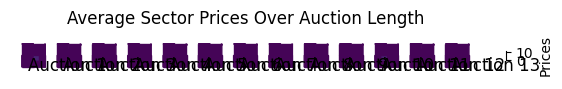

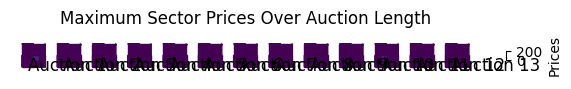

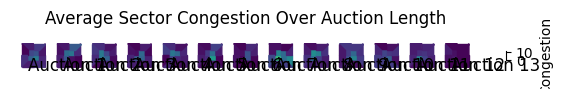

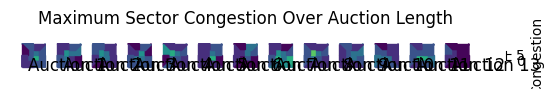

In [187]:
# Pull data from all auction times in the folder
# run_path = "results/toulouse_case_cap4_updated_fisher_b-50.0_agents20_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_122848/"
run_path = "results/toulouse_case_cap8_updated_20_fisher_b-50.0_agentsall_dval40.0_outval1.0_pout1.0_freq500.0_pbound3000.0_receding_20250218_140711/"
auction_times = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]
data = {auction_time: retrieve_data(run_path, f"results/fisher_data_{auction_time}.pkl") for auction_time in auction_times}

# Gather prices and congestion data
avg_sector_prices_list, avg_sector_congestion_list, max_sector_prices_list, max_sector_congestion_list = [], [], [], []
for auction_time, (goods, good_prices, allocation) in data.items():
    max_time, region_price_vs_time, region_congestion_vs_time, sector_prices, sector_congestion = find_region_prices_and_congestion(goods, good_prices, allocation)
    avg_sector_prices_list.append({sector: sum(prices.values()) / 20 for sector, prices in sector_prices.items()})
    avg_sector_congestion_list.append({sector: sum(congestion.values()) / 20 for sector, congestion in sector_congestion.items()})
    max_sector_prices_list.append({sector: max(prices.values(), default=0) for sector, prices in sector_prices.items()})
    max_sector_congestion_list.append({sector: max(congestion.values(), default=0) for sector, congestion in sector_congestion.items()})

# Plot the heatmap of the sector prices
plot_multi_auction_prices_and_congestion(avg_sector_prices_list, max_sector_prices_list, avg_sector_congestion_list, max_sector_congestion_list, run_path, max_time)


In [57]:
import pandas as pd

# Fairness Histogram
df = pd.read_csv('results/modified_toulouse_case3_withC_cap5_withReturn_fisher_100.0_1.0_1.0_1.0_2.0_500.0/final.csv')
print(data.columns)

adjusted_valuation = []
for val, delay, status in zip(df['Valuation'], df['Delay'], df['Status']):
    if status != 'dropped':
        adjusted_valuation.append(val * (0.95 ** delay))
    else:
        adjusted_valuation.append(1)
df['adjusted_valuation'] = adjusted_valuation

# Step 3: Create a figure and axis for the plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(df['Agent']))

# Step 4: Plot budget on the first axis
bar_width = 0.25
ax1.bar(x-bar_width, df['Ori. Budget'], bar_width, color='b', alpha=0.6, label='Budget')
ax1.set_xlabel('Agent Name')
ax1.set_ylabel('Budget', color='b')
ax1.set_xticks(x)
ax1.set_xticklabels(df['Agent'], rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='b')

# Step 5: Create a second y-axis for valuation and adjusted valuation
ax2 = ax1.twinx()

# Plot valuation and adjusted valuation
ax2.bar(x, df['Valuation'], bar_width, color='g', label='Desired Utility')
ax2.bar(x+bar_width, df['adjusted_valuation'], bar_width, color='r', label='Utility')

# Label the second y-axis
ax2.set_ylabel('Utility', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add a legend for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.title('Budget, Utility, and Adjusted Utility for Agents')
plt.savefig(run_path + 'budget_utility_adjusted_utility_int.png')
plt.show()

percentage_utility = df['adjusted_valuation'] / df['Valuation']
plt.plot(df['Ori. Budget'], percentage_utility, 'o')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/modified_toulouse_case3_withC_cap5_withReturn_fisher_100.0_1.0_1.0_1.0_2.0_500.0/final.csv'